# Setup

This cell checks if `Dedalus` is installed and performs some other basic setup.

If `Dedalus` is not installed and you are using `Google Colab`, it will automatically be installed.
This may take a few minutes the first time you run the notebook, but subsequent sessions during the next day or so should have the installation cached.
No need to worry about the details - **just execute the cell**.

If you are not using `Google Colab`, follow the installation instructions in the [`Dedalus` Docs](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html) to install `Dedalus` locally on your computer.
Installation using `conda` is typically straightforward for Mac and Linux.
No promises on Windows.
Execute the cell to confirm `Dedalus` is installed and importable.

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:

    import dedalus.public as de
    print("\nDedalus already installed")

except:

    print("\nDedalus not installed yet")

    if using_google_colab:

        print("\nInstalling for Google Colab\n")

        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev

        # Step 2: Set paths for Dedalus installation
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"

        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py < 4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl

        # Step 4: Check installation
        try:
            import dedalus.public as de
            print("\nDedalus was successfully installed. The Google Colab session will now restart")

            import os
            os._exit(0)
        except:
            print("\nError installing Dedalus")
            raise

    else:

        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:

    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1

Dedalus already installed


# Forcing and Analysis - 2D Turbulence

**Overview:** This notebook describes how to construct a forced 2D turbulence simulation and analyze the output.

**About `Dedalus`:** [`Dedalus`](http://dedalus-project.org) is an open-source Python package for solving partial differential equations (PDEs) using global spectral methods.
These methods yield highly accurate numerical solutions for PDEs with smooth solutions in simple domains like boxes and spheres.
`Dedalus` incorporates modern parallel algorithms with sparse polynomial bases, all accessible through an intuitive symbolic interface.
The code has been widely applied across diverse fields, particularly in problems involving fluid dynamics.

**Author:** [Keaton Burns](http://keaton-burns.com)

First let's import everything we need to run the rest of the notebook.

In [2]:
%matplotlib widget

import numpy as np
np.seterr(over="raise")

import matplotlib.pyplot as plt

import dedalus.public as d3

root_logger = logging.getLogger()
if root_logger.handlers:
    for handler in root_logger.handlers:
        root_logger.removeHandler(handler)

# import logging
logger = logging.getLogger(__name__)

## 1. Setup domain and fields

We begin by setting up the domain for a forced 2D turbulence simulation.
We'll take as our domain a doubly-periodic box of size $L = 2 \pi$, discretized with $N$ Fourier modes in each dimension.

We first create a Cartesian coordinate system, then a `Distributor` object, and finally `RealFourier` bases for each dimension.
Since we'll be solving Navier-Stokes with quadratic nonlinearities, we'll pick the dealias factors to be `3/2`.

In [3]:
# Domain parameters
L = 2 *np.pi
N = 512
mesh = None
dtype = np.float64
dealias = 3 /2

# Domain
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, mesh=mesh, dtype=dtype)
xbasis = d3.RealFourier(coords[0], N, bounds=(0, L), dealias=dealias)
ybasis = d3.RealFourier(coords[1], N, bounds=(0, L), dealias=dealias)

Next, we create the fields required for the simulation.
For incompressible 2D flow, we can use the streamfunction–vorticity formulation to simplify the enforcement of incompressibility and to accelerate the computation.
This approach requires defining only the streamfunction, $\psi$, as the variable field to be solved.
We also create a constant field, $c$, which will be used to set the gauge freedom in the streamfunction–vorticity formulation.

In [4]:
# Fields
psi = dist.Field(name='psi', bases=(xbasis, ybasis))
c = dist.Field(name='c')

We do not need to define additional fields to represent the velocity or vorticity.
These quantities can be expressed entirely as symbolic expressions based on the streamfunction, using the vector calculus operators provided by `Dedalus`.
This approach simplifies both the specification of equations and subsequent analysis tasks.

In [5]:
# Substitutions
u = -d3.skew(d3.grad(psi))  # velocity vector: [dy(psi), -dx(psi)]
w = -d3.lap(psi)            # vorticity: dx(uy) -dy(ux)
e = (u @u) /2               # energy density
z = (w *w) /2               # enstrophy density

## 2. Stochastic forcing

To achieve a statistically steady turbulent state, we use stochastic band-limited forcing with a prescribed energy injection rate.
First, we specify the energy injection rate, primary wavenumber, and bandwidth of the stochastic forcing.
We then create a field, `Fw`, whose values are updated with a new random forcing at every iteration, and define functions to perform this update.

The precise normalization of forcings like this can be tricky, but it is important for accurately controlling the rate of energy injection.
Here, we create a normalized Gaussian random field with support concentrated on a ring in Fourier space.
We also define a function that scales this forcing according to the timestep, as required for a stochastic integrator, and sets the coefficients of the `Fw` field.

In [6]:
# Forcing parameters
epsilon = 1     # Energy injection rate
kf = 50         # Forcing wavenumber
kfw = 2         # Forcing bandwidth
seed = None     # Random seed

# Derived parameters
eta = epsilon *kf**2  # Enstrophy injection rate

# Forcing field and derived parameters
Fw = dist.Field(name='Fw', bases=(xbasis, ybasis))
kx = xbasis.wavenumbers[dist.local_modes(xbasis)]
ky = ybasis.wavenumbers[dist.local_modes(ybasis)]
dkx = dky = 2 *np.pi /L

# Forcing function
rand = np.random.RandomState(seed)

def draw_gaussian_random_field():
    """
    Create Gaussian random field concentrating on a ring in Fourier space with unit variance.
    """
    k = (kx**2 +ky**2)**0.5

    # 1D power spectrum: normalized Gaussian, no mean
    P1 = np.exp(-(k -kf)**2 /2 /kfw**2) /np.sqrt(kfw**2 *np.pi /2) *(k != 0)

    # 2D power spectrum: divide by polar Jacobian
    P2 = P1 /2 /np.pi /(k +(k==0))

    # 2D coefficient poewr spectrum: divide by mode power
    Pc = P2 /2**((kx == 0).astype(float) +(ky == 0).astype(float) -2)

    # Forcing amplitude, including division between sine and cosine
    f_amp = (Pc /2 *dkx *dkx)**0.5

    # Forcing with random phase
    f = f_amp *rand.randn(*k.shape)

    return f

def set_vorticity_forcing(timestep):
    """
    Set vorticity forcing field from scaled Gaussian random field.
    """
    # Set forcing to normalized Gaussian random field
    Fw['c'] = draw_gaussian_random_field()

    # Rescale by forcing rate, including factor for 1/2 in kinetic energy
    Fw['c'] *= (2 *eta /timestep)**0.5

## 3. Build problem and solver

Next, we can build the `Problem` and `Solver` objects for our simulation.
Our PDE describes 2D incompressible Navier–Stokes flow in the streamfunction–vorticity formulation.
We will include large-scale drag to allow the simulation to reach energy equilibrium:

$$\partial_t \omega + \vec{u} \cdot \nabla \omega = - \alpha \, \omega + \nu \, \nabla^2 \omega + F_\omega
\omega = - \nabla^2 \psi$$

Since we have symbolically defined $\omega$ in terms of $\psi$ via the Laplacian, we do not need to include this as an additional equation.
However, this formulation introduces a gauge freedom in the mean value of the streamfunction.
This gauge must be fixed to obtain a well-posed problem.
We achieve this by adding the undetermined constant field $c$ to the vorticity equation, effectively absorbing the mean mode of the vorticity equation, which would otherwise read $0 = 0$.
This allows us to impose an additional constraint to fix the streamfunction gauge.

In [7]:
# Problem parameters
L_diss = L /N   # Dissipation scale
L_fric = L      # Friction scale

# Derived parameters
nu = L_diss**2 *eta**(1/3)               # Viscosity
alpha = epsilon**(1/3) *L_fric**(-2/3)   # Friction

# Problem
problem = d3.IVP([psi, c], namespace=locals())
problem.add_equation("dt(w) -nu *lap(w) +alpha *w +c = -u @grad(w) +Fw")
problem.add_equation("integ(psi) = 0");

Running multidimensional simulations on a single core in a notebook can be somewhat slow

In [8]:
# Solver parameters
timestepper = d3.RK222
stop_sim_time = 5

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2025-10-22 15:03:16,971 subsystems 0/1 INFO :: Building subproblem matrices 1/256 (~0%) Elapsed: 0s, Remaining: 44s, Rate: 5.9e+00/s
2025-10-22 15:03:18,064 subsystems 0/1 INFO :: Building subproblem matrices 26/256 (~10%) Elapsed: 1s, Remaining: 11s, Rate: 2.1e+01/s
2025-10-22 15:03:19,493 subsystems 0/1 INFO :: Building subproblem matrices 52/256 (~20%) Elapsed: 3s, Remaining: 11s, Rate: 1.9e+01/s
2025-10-22 15:03:21,410 subsystems 0/1 INFO :: Building subproblem matrices 78/256 (~30%) Elapsed: 5s, Remaining: 11s, Rate: 1.7e+01/s
2025-10-22 15:03:23,330 subsystems 0/1 INFO :: Building subproblem matrices 104/256 (~41%) Elapsed: 7s, Remaining: 10s, Rate: 1.6e+01/s
2025-10-22 15:03:24,511 subsystems 0/1 INFO :: Building subproblem matrices 130/256 (~51%) Elapsed: 8s, Remaining: 7s, Rate: 1.7e+01/s
2025-10-22 15:03:25,753 subsystems 0/1 INFO :: Building subproblem matrices 156/256 (~61%) Elapsed: 9s, Remaining: 6s, Rate: 1.7e+01/s
2025-10-22 15:03:26,854 subsystems 0/1 INFO :: Building 

## 4. Analysis tasks

To simplify saving simulation data, `Dedalus` provides a framework for evaluating and storing arbitrary analysis tasks while an initial value problem is running.
These analysis tasks can be specified symbolically and are saved to `HDF5` files.

**Analysis Handlers**

The explicit evaluation of analysis tasks during time-stepping is managed by the `solver.evaluator` object.
Various handler objects can be attached to the evaluator, which determine when tasks are computed and how the resulting data is processed.
For simulation analysis, the most useful handler is the `FileHandler`, which periodically evaluates tasks and writes the results to `HDF5` files.

When setting up a file handler, you specify the name/path of the output directory or files, as well as the cadence at which the handler’s tasks should be evaluated.
This cadence can be defined in terms of any combination of:

* simulation time (`sim_dt`)
* wall time (`wall_dt`)
* iteration count (`iter`)

To limit file sizes, the output from a file handler is split into different “sets” over time, with each set containing a fixed number of writes.
This limit can be controlled using the `max_writes` keyword when the file handler is constructed.
You can add any number of file handlers to save different sets of tasks at different cadences and to different files.

**Analysis tasks**

Analysis tasks are added to a handler using the `add_task` method.
Tasks can be specified either as operator expressions or as plain text, and are parsed using the same namespace that is used for equation entry.
For each task, you can also specify the output layout, scaling factors, and a reference name.

As an example, let’s create two different handlers: one for saving simulation snapshots, and another for saving scalar summary statistics at a higher cadence.

In [9]:
# Analysis parameters
snapshots_dt = 0.1
scalars_dt = 0.01

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=snapshots_dt, max_writes=1, mode='overwrite')
snapshots.add_task(psi, name='psi')
snapshots.add_task(w, name='vorticity')

scalars = solver.evaluator.add_file_handler('scalars', sim_dt=scalars_dt, mode='overwrite')
ave = d3.Average
scalars.add_task(ave(e), name='E')
scalars.add_task(ave(z), name='Z')
scalars.add_task(ave(-alpha *2 *e), name='E friction')
scalars.add_task(ave(-alpha *2 *z), name='Z friction')
scalars.add_task(ave(nu *u @d3.lap(u)), name='E viscosity')
scalars.add_task(ave(nu *w *d3.lap(w)), name='Z viscosity')

## 5. Adaptive timestepping and main loop

For more complex simulations, using a constant timestep may be too restrictive.
In such cases, it is often preferable to choose the timestep adaptively based on a CFL criterion.
`Dedalus` provides a CFL tool for this purpose, with several optional parameters that help avoid unnecessary timestep changes (which can be computationally costly) and keep the timestep within reasonable bounds.

Below is an example of setting up a CFL criterion based on an estimate of the expected RMS velocity, along with some typical parameter choices for the CFL options:

In [10]:
# Timestepping parameters
dx = L /N                           # Grid spacing
U = epsilon**(1/3) *L_fric**(1/3)   # Friction velocity
safety = 0.5                        # CFL safety factor
max_dt = safety *dx /U              # Timestep

# CFL
CFL = d3.CFL(solver, initial_dt=max_dt, cadence=10, safety=safety, max_change=1.5, min_change=0.5, max_dt=max_dt, threshold=0.05)
CFL.add_velocity(u)

We can now run the simulation just as in the previous tutorial, but without manually saving any data during the main loop.
The evaluator automatically computes and stores the specified analysis tasks at the chosen cadence as the simulation progresses.

At each iteration, we first compute the new timestep using the `CFL.compute_timestep` method.
We then update the random forcing and advance the simulation by one step with this timestep.
Finally, after the simulation completes, we can print common run statistics using `solver.log_stats()`.

In [11]:
# Main loop
try:
    logger.info('Starting loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        set_vorticity_forcing(timestep)
        solver.step(timestep)
        if (solver.iteration -1) % 10 == 0:
            logger.info(f'Iteration={solver.iteration:4d}, Time={solver.sim_time:e}, dt={timestep}')
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2025-10-22 15:03:29,323 __main__ 0/1 INFO :: Starting loop
2025-10-22 15:03:32,923 __main__ 0/1 INFO :: Iteration=   1, Time=3.325217e-03, dt=0.003325216720192143
2025-10-22 15:03:40,642 __main__ 0/1 INFO :: Iteration=  11, Time=3.657738e-02, dt=0.003325216720192143
2025-10-22 15:03:45,335 __main__ 0/1 INFO :: Iteration=  21, Time=6.982955e-02, dt=0.003325216720192143
2025-10-22 15:03:49,341 __main__ 0/1 INFO :: Iteration=  31, Time=1.030817e-01, dt=0.003325216720192143
2025-10-22 15:03:52,489 __main__ 0/1 INFO :: Iteration=  41, Time=1.363339e-01, dt=0.003325216720192143
2025-10-22 15:03:55,647 __main__ 0/1 INFO :: Iteration=  51, Time=1.695861e-01, dt=0.003325216720192143
2025-10-22 15:03:59,027 __main__ 0/1 INFO :: Iteration=  61, Time=2.028382e-01, dt=0.003325216720192143
2025-10-22 15:04:02,925 __main__ 0/1 INFO :: Iteration=  71, Time=2.360904e-01, dt=0.003325216720192143
2025-10-22 15:04:06,417 __main__ 0/1 INFO :: Iteration=  81, Time=2.668857e-01, dt=0.003079535750358099
2025-

## 6. Post-processing

By default, the output files generated by each file handler are organized as follows:

1.	A base folder, named according to the string provided when the file handler was constructed (e.g., `scalars/`).
2.	Inside the base folder, `HDF5` files are created for each output set, with filenames following the same base name plus a set number (e.g., `scalars_s1.h5`).

Each `HDF5` file contains a tasks group, which stores a dataset for every task assigned to the file handler.
The first dimension of each dataset corresponds to time. The subsequent dimensions represent the vector or tensor components of the task (if applicable), followed by the spatial dimensions.

The `HDF5` datasets are fully self-describing, with dimensional scales attached to each axis.

* For the time axis, these include simulation time, wall time, iteration, and write number.
* For the spatial axes, the scales correspond to either grid points or modes, depending on the task layout.

As an example, let’s open the first scalars set file and plot a time series of the average kinetic energy and enstrophy:

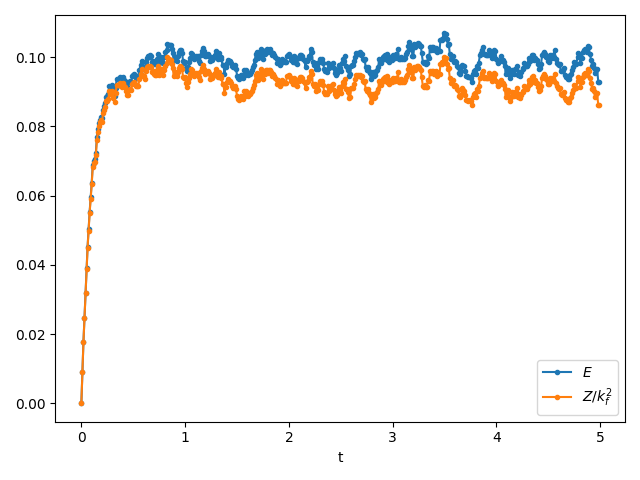

In [12]:
import h5py

# Load energy and enstrophy traces
scalars = h5py.File('scalars/scalars_s1.h5', mode='r')
E = scalars['tasks']['E'][:]
Z = scalars['tasks']['Z'][:]
t = scalars['tasks']['E'].dims[0]['sim_time'][:]

# Plot data
plt.figure()

plt.plot(t, E.ravel(), '.-', label=r'$E$')
plt.plot(t, Z.ravel() /kf**2, '.-', label=r'$Z /k_f^2$')

plt.xlabel('t')
plt.legend()
plt.tight_layout()

Let’s open the second snapshot set file and plot the vorticity field at the final saved timestep.

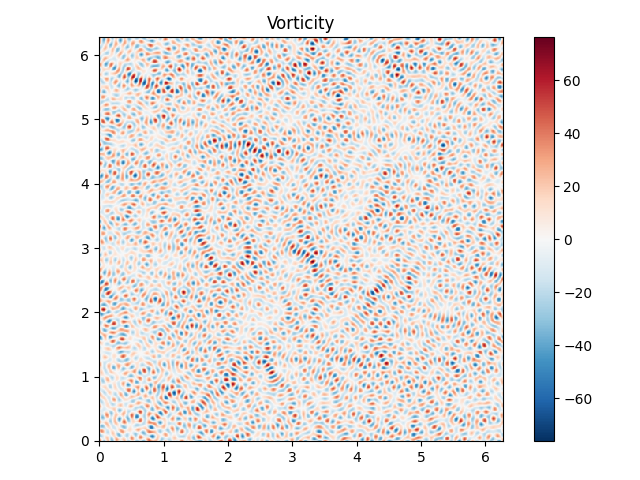

In [13]:
# Load energy and enstrophy traces
snapshots = h5py.File('snapshots/snapshots_s2.h5', mode='r')
psi = snapshots['tasks']['psi'][:]
w = snapshots['tasks']['vorticity'][:]
x = snapshots['tasks']['vorticity'].dims[1]['x'][:]
y = snapshots['tasks']['vorticity'].dims[2]['y'][:]

# Plot data
clim = np.max(np.abs(w[-1]))

plt.figure()

plt.pcolormesh(x, y, w[-1], cmap='RdBu_r', clim=(-clim, clim))
plt.axis('scaled')
plt.colorbar()
plt.title('Vorticity')
plt.tight_layout()

Finally let's plot the power spectrum of the solution.
This can be done by directly saving coefficient-space data from `Dedalus` (pass `layout='c'` in the `add_task` method), or simply by using `NumPy` FFTs to change our grid-space data to complex coefficients.
Let's do that here. Again be careful of normalizations if you want to get the amplitude right - `NumPy` FFTs and `Dedalus` FFTs are normalized differently.

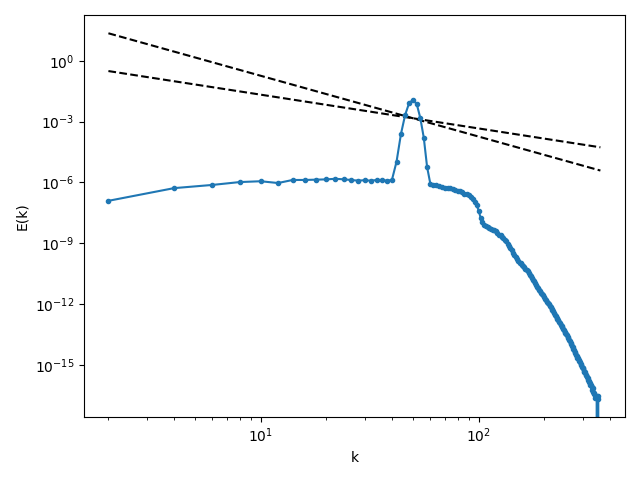

In [14]:
# Setup frequency bins
kx = np.fft.fftfreq(N, 1/N)[:, None]
ky = np.fft.fftfreq(N, 1/N)[None, :]
k = (kx**2 +ky**2)**0.5
kmax = int(np.ceil(np.max(k)))

bins = np.arange(1, kmax +1, 2)
kcen = bins[:-1] +np.diff(bins) /2

# Use renormalized numpy FFT to compute power spectrum
E_k2 = np.abs(np.fft.fft2(psi[-1]) /N**2)**2 *k**2
E_k1 = E_k2 *2 *np.pi *k

# Build histogram over modes, weighted by energy
pow_samples, _ = np.histogram(k, bins=bins, weights=E_k1)
hist_samples, _ = np.histogram(k, bins=bins)
spectrum = pow_samples /hist_samples /2

# Plot histogram
plt.figure()

plt.loglog(kcen, epsilon**(2/3) *kcen**(-5/3), '--k')
plt.loglog(kcen, eta**(2/3) *kcen**(-3), '--k')
plt.loglog(kcen, spectrum, '.-')

plt.xlabel("k")
plt.ylabel("E(k)")
plt.tight_layout()